# Tactical Deception Model

> A replication and extension of the paper (Luke McNally and Andrew L. Jackson, 2013): Cooperation creates selection for tactical deception 

In [2]:
#| default_exp tactical_deception

In [1]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.data_utils import *
from gh_pages_example.methods import *
from gh_pages_example.models import *
from gh_pages_example.model_utils import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import copy
import typing
import warnings

import chaospy
import fastcore.test
import ipywidgets
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import scipy
import seaborn as sns

/home/ethos/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


In [70]:
@multi
def build_payoffs(models: dict):
    return models.get('payoffs_key')

@method(build_payoffs, 'tactical_deception_v1')
def build_payoffs(models: dict):
    names = ['population_state', "profile", "player",]
    population_state, profile, player = [models[k] for k in names]
    names = 'c', 'b', 's', 'd'
    c, b, s, d = [models[k] for k in names]
    strategy_counts = population_state["strategy_counts"]
    assert len(string_to_tuple(profile))==2
    assert player in ["P1", "P2"]
    x_td = (strategy_counts.get("3", 0)
            / (strategy_counts.get("1", 0)
               + strategy_counts.get("2", 0)
               + strategy_counts.get("3", 0)))
    # 1 is a conditional cooperator (CC)
    # 2 is a honest defector (HD)
    # 3 is a tactical deceiver (TD)
    # Conditional cooperators fail to identify defectors with chance s
    # and cooperate with defectors with chance s
    # Conditional cooperators fail to identify tactical deceivers with chance q
    # and cooperate with tactical deceives with chance q + s - q*s
    # q is frequency dependent. The higher density of tactical deceivers in the
    # population, x_td, the smaller q is
    q = 1 - x_td
    
    # Assume that b – c > sb > 0, q > 0, s < 1 and c > d > 0,
    # This ensures bistability between CC and HD
    # CCs do not dominate TDs, and HDs dominate TDs
    primitives = {"1-1": {"P1": b-c, "P2": b-c},
                  "1-2": {"P1": -c*s, "P2": b*s},
                  "1-3": {"P1": -c*(q + s - q*s),
                          "P2": b*(q + s - q*s) - d},
                  "2-1": {"P1": b*s, "P2": -c*s},
                  "2-2": {"P1": 0, "P2": 0},
                  "2-3": {"P1": 0, "P2": -d},
                  "3-1": {"P1": b*(q + s - q*s) - d,
                          "P2": -c*(q + s - q*s)},
                  "3-2": {"P1": -d, "P2": 0},
                  "3-3": {"P1": -d, "P2": -d},}
    payoff = primitives[profile][player]
    return payoff

def payoffs_tactical_deception_v1(models: dict):
    return build_payoffs(assoc(models, "payoffs_key", 'tactical_deception_v1'))

In [78]:
Z = {"S1": 50}
β = 1
sector_strategies = {"S1": [1, 2, 3],}
allowed_sectors = {"P2": ["S1"],
                   "P1": ["S1"], }
models_base = {"payoffs_key": "tactical_deception_v1",
               "payoffs_function": payoffs_tactical_deception_v1,
               "dispatch-type": 'multiple-populations',
               "compute_success_rule": "functional",
               "sd-method": "quantecon",
               "β": β,
               "Z": Z,
               "allowed_sectors": allowed_sectors,
               "sector_strategies": sector_strategies,
               }

In [84]:
args = {"b": np.arange(1, 4, 0.05),
        "c": [0.5],
        "s": [0.1, 0.2, 0.3],
        "d": np.arange(0, 0.5, 0.05),
        "β": [0.01, 0.1, 1, 10],
        }

models = {**models_base,
          **model_builder(args)}
models["n_models"] = models["β"].shape[0]
models["payoffs"] = {"1-1": {"P1": 0 }} # Dummy payoffs we won't use
models['learning_rate'] = models['β']
models['β'] = {"S1": models['β'],}

In [85]:
{k:v.shape for k, v in models.items() if isinstance(v, np.ndarray)}

{'b': (7200,),
 'c': (7200,),
 's': (7200,),
 'd': (7200,),
 'learning_rate': (7200,)}

In [86]:
models

{'payoffs_key': 'tactical_deception_v1',
 'payoffs_function': <function __main__.payoffs_tactical_deception_v1(models: dict)>,
 'dispatch-type': 'multiple-populations',
 'compute_success_rule': 'functional',
 'sd-method': 'quantecon',
 'β': {'S1': array([ 0.01,  0.1 ,  1.  , ...,  0.1 ,  1.  , 10.  ])},
 'Z': {'S1': 50},
 'allowed_sectors': {'P2': ['S1'], 'P1': ['S1']},
 'sector_strategies': {'S1': [1, 2, 3]},
 'b': array([1.  , 1.  , 1.  , ..., 3.95, 3.95, 3.95]),
 'c': array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]),
 's': array([0.1, 0.1, 0.1, ..., 0.3, 0.3, 0.3]),
 'd': array([0.  , 0.  , 0.  , ..., 0.45, 0.45, 0.45]),
 'n_models': 7200,
 'payoffs': {'1-1': {'P1': 0}},
 'learning_rate': array([ 0.01,  0.1 ,  1.  , ...,  0.1 ,  1.  , 10.  ])}

In [87]:
results = thread_macro(models,
                        create_profiles,
                        apply_profile_filters,
                        build_transition_matrix,
                        find_ergodic_distribution,
                        calculate_sd_helper,
                        )
df = thread_macro(results,
                  results_to_dataframe_egt,)

/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:1452: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ΠB.append(np.dot(np.array(payoffsB).T, likelihoodsB))


/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:1442: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ΠA.append(np.dot(np.array(payoffsA).T, likelihoodsA))
/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:492: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


In [88]:
df

,b,c,s,d,learning_rate,1_frequency,2_frequency,3_frequency
0,1.00,0.5,0.1,0.00,0.01,0.386561,3.148710e-01,2.985683e-01
1,1.00,0.5,0.1,0.00,0.10,0.806403,1.285953e-01,6.500190e-02
2,1.00,0.5,0.1,0.00,1.00,1.000000,1.276249e-07,1.249284e-08
3,1.00,0.5,0.1,0.00,10.00,1.000000,3.853318e-69,1.041052e-70
4,1.00,0.5,0.1,0.05,0.01,0.386504,3.148227e-01,2.986729e-01
...,...,...,...,...,...,...,...,...
7195,3.95,0.5,0.3,0.40,10.00,1.000000,1.943581e-219,2.106742e-219
7196,3.95,0.5,0.3,0.45,0.01,0.647083,1.875349e-01,1.653824e-01
7197,3.95,0.5,0.3,0.45,0.10,0.999991,8.000563e-06,1.394223e-06
7198,3.95,0.5,0.3,0.45,1.00,1.000000,3.396616e-51,1.147308e-52


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='b', ylabel='d'>,
 <matplotlib.image.AxesImage at 0x7f7da66d06a0>)

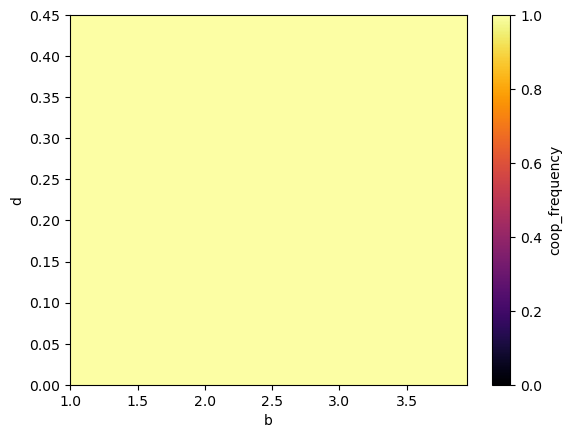

In [100]:
df['coop_frequency'] = df["1_frequency"]
df_filtered = df[(df["learning_rate"]==10)
                 & (df["s"]==0.2)]
table = df_filtered.pivot_table(index='d', columns='b', values='coop_frequency')
plot_heatmap(table, xlabel="b", ylabel="d", zlabel="coop_frequency")

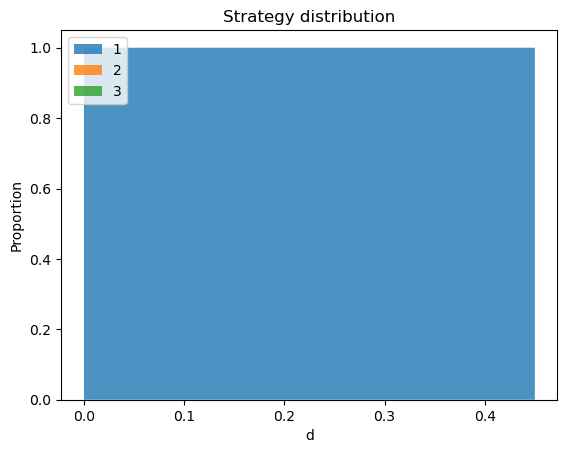

In [101]:
plot_strategy_distribution(df_filtered, strategy_set=[f"{i}" for i in range(1,4)], x="d",
                           thresholds=None, x_label="d")